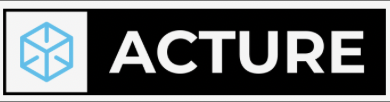



---



---


# CUSTOM OBJECT DETECTION TRAINING NOTEBOOK V3.2
The code cells in this notebook will require the user to either simply 'Run' the cell to do the necessary actions, or will require 'User Action' to do certain actions like upload images, a label map, etc.

Requirements:

1.   A premade label_map.pbtx file (you can follow the format shown in step four - this is pretty simple and you can do it when you get there).
2.   Images for training (.jpg format) with the annotations saved as .xml files in the Pascal VOC format (see the docs - recommendation is to use labelImg program).
3. Save a copy of this notebook when using it for your own models so that we can preserve this template

NOTES:
- These notebooks do disconncect from the host machine at Google after a timeout and you will lose the work done. It is best to use this notebook in a single sitting to avoid this and to download your model before exiting.
- For trainging a model you should switch the runtime to a GPU instance. This can be done in the tool bar on the top left by selecting Runtime -> Change runtime type -> Hardware accelerator = GPU. It is about 10 times faster

# **0) USER ACTION: MAKE A COPY OF THIS NOTEBOOK**
This will preserve this template for other users. You can do this by going to File > Save a copy in Drive. Once you have a copy made and it is your current workspace you should then make sure you changed your runtime type as detailed in the NOTES section above.

In [1]:
#@title  ## **1) RUN: Importing the tensorflow library and IPython Libraries**
#@markdown If successful you should see see something similar to the following on the last line:
#@markdown
#@markdown ```
#@markdown tf.Tensor(-305.13428, shape=(), dtype=float32)
#@markdown ```
#@markdown ---

import ipywidgets as widgets
import tensorflow
! python -c "import tensorflow as tf;print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

2021-02-19 06:00:15.206202: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-19 06:00:16.925430: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-19 06:00:16.926398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-19 06:00:16.986383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-19 06:00:16.986998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-19 06:00:16.987041: I tensorflow/stream_executor/platform/default/dso_loade

In [2]:
#@title  ##  **2) RUN: Pick a Model to use for the training**
#@markdown You must run this cell before picking an option from the list below.
#@markdown
#@markdown You can check the metrics (speed and precision) for each of the base models here:
#@markdown
#@markdown https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md


model_links={'CenterNet HourGlass104 512x512': 'http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz', 
             'CenterNet HourGlass104 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz', 
             'CenterNet Resnet50 V1 FPN 512x512': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz',
             'CenterNet Resnet101 V1 FPN 512x512': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet101_v1_fpn_512x512_coco17_tpu-8.tar.gz',
             'CenterNet Resnet50 V2 512x512': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz',
             'EfficientDet D0 512x512': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz',
             'EfficientDet D1 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz', 
             'EfficientDet D2 768x768': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz', 
             'EfficientDet D3 896x896': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d3_coco17_tpu-32.tar.gz', 
             'EfficientDet D4 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz',
             'EfficientDet D5 1280x1280': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz', 
             'EfficientDet D6 1280x1280': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz', 
             'EfficientDet D7 1536x1536': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d7_coco17_tpu-32.tar.gz' , 
             'SSD MobileNet v2 320x320': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
             'SSD MobileNet V1 FPN 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz', 
             'SSD MobileNet V2 FPNLite 320x320': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz', 
             'SSD MobileNet V2 FPNLite 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz',
             'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz', 
             'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz', 
             'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz', 
             'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8.tar.gz', 
             'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_640x640_coco17_tpu-8.tar.gz', 
             'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8.tar.gz', 
             'Faster R-CNN ResNet50 V1 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz',
             'Faster R-CNN ResNet50 V1 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8.tar.gz', 
             'Faster R-CNN ResNet50 V1 800x1333': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8.tar.gz', 
             'Faster R-CNN ResNet101 V1 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz',
             'Faster R-CNN ResNet101 V1 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz', 
             'Faster R-CNN ResNet101 V1 800x1333': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_800x1333_coco17_gpu-8.tar.gz',
             'Faster R-CNN ResNet152 V1 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_640x640_coco17_tpu-8.tar.gz',
             'Faster R-CNN ResNet152 V1 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz', 
             'Faster R-CNN ResNet152 V1 800x1333': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8.tar.gz', 
             'Faster R-CNN Inception ResNet V2 640x640': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz',
             'Faster R-CNN Inception ResNet V2 1024x1024': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz', 
             'ExtremeNet': 'http://download.tensorflow.org/models/object_detection/tf2/20200711/extremenet.tar.gz'}

model_select = widgets.RadioButtons(
    options=model_links.keys(),
    value='SSD MobileNet V2 FPNLite 640x640', # Defaults to 'pineapple'
    layout={'width': 'max-content'}, # If the items' names are long
    description='MODEL:',
    disabled=False
)
display(model_select)

#@markdown ---

RadioButtons(description='MODEL:', index=16, layout=Layout(width='max-content'), options=('CenterNet HourGlass…

In [3]:
#@title ## **3) RUN: Creating the folder directory structure to follow the instruction set listed at the docs:**
#@markdown https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html
#@markdown
#@markdown If successful, you should be able to click the folder icon on the left hand side tool bar and see a folder directory structure. Navigate up one folder level and you should see the TensorFlow directory at the top.
#@markdown 
#@markdown ---
% cd /
% mkdir TensorFlow
% cd /TensorFlow/
% mkdir addons workspace scripts
% cd /TensorFlow/
! wget https://github.com/tensorflow/models/archive/c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip
! unzip /TensorFlow/c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip
! rm /TensorFlow/c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip
!mv /TensorFlow/models-c33d6bae8ea10a6afe37590871a06e0e9e0b4133 /TensorFlow/models
% cd /TensorFlow/models
% cd /TensorFlow/workspace/
% mkdir training_demo
% cd /TensorFlow/workspace/training_demo/
% mkdir annotations exported-models images models pre-trained-models
% cd /TensorFlow/workspace/training_demo/images/
% mkdir train test
% cd /TensorFlow/scripts/
% mkdir preprocessing
% cd /TensorFlow/scripts/preprocessing/
#! wget https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py
! git clone https://github.com/tylerbellenfant/preprocessing.git
#! cp /TensorFlow/models/research/object_detection/dataset_tools/create_pascal_tf_record.py /TensorFlow/scripts/preprocessing/
! pip install pandas
% cd /TensorFlow/models/research/
! python -m pip install .
! apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
% cd /TensorFlow/models/research/ 
! pip install git+https://github.com/google-research/tf-slim.git
! pip install -q Cython contextlib2 pillow lxml matplotlib
! pip install -q pycocotools
! protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += '/TensorFlow/models/research/:/TensorFlow/models/research/slim/'

% cd /
% mkdir TensorFlow
% cd /TensorFlow/
% mkdir addons workspace scripts
% cd /TensorFlow/models
% cd /TensorFlow/workspace/
% mkdir training_demo
% cd /TensorFlow/workspace/training_demo/
% mkdir annotations exported-models images models pre-trained-models
% cd /TensorFlow/workspace/training_demo/images/
% mkdir train
% cd /TensorFlow/scripts/
% mkdir preprocessing
% cd /TensorFlow/scripts/preprocessing/
#! wget https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py
! pip install pandas
% cd /TensorFlow/models/research/
! python -m pip install .
! apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
% cd /TensorFlow/models/research/ 
! pip install git+https://github.com/google-research/tf-slim.git
! pip install -q Cython contextlib2 pillow lxml matplotlib
! pip install -q pycocotools
! protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += '/TensorFlow/models/research/:/TensorFlow/models/research/slim/'


print("FILE DIRECTORY STRUCTURE CREATED. YOU MAY PROCEED TO THE NEXT STEP :)")

/
/TensorFlow
/TensorFlow
--2021-02-19 06:01:02--  https://github.com/tensorflow/models/archive/c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tensorflow/models/zip/c33d6bae8ea10a6afe37590871a06e0e9e0b4133 [following]
--2021-02-19 06:01:02--  https://codeload.github.com/tensorflow/models/zip/c33d6bae8ea10a6afe37590871a06e0e9e0b4133
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip’

c33d6bae8ea10a6afe3     [        <=>         ]  31.86M  18.6MB/s    in 1.7s    

2021-02-19 06:01:04 (18.6 MB/s) - ‘c33d6bae8ea10a6afe37590871a06e0e9e0b4133.zip

---


# **4) USER ACTION: Create and upload a label_map.pbtxt**

TensorFlow **requires a label map**, which namely maps each of the used labels to an integer values. This label map is used both by the training and detection processes. Label map files have the extention .pbtxt and should be placed inside the training_demo/annotations folder. **Create a file called label_map.pbtxt and upload it to the /TensorFlow/workspace/training_demo/annotations/ folder.** An example of what a .pbtxt file contains is shown here (note that the id numbering starts at 1 - this is because 0 is reserved):



```
item {
    id: 1
    name: 'cat'
}

item {
    id: 2
    name: 'dog'
}
```






---


# **5) USER ACTION: Upload Images and their XML Files**
Upload the training .jpg images and their respective annotative .xml files to the 'train' folder under /TensorFlow/workspace/training-demo/images


---



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#@title # **6) RUN: Downloading TF Record Converter Script and Running It**

#@markdown Verify that a *train.record* file is present in the /TensorFlow/workspace/training_demo/annotations folder and that you see the following line after running this step:


#@markdown ```
#@markdown Successfully created the TFRecord file: /TensorFlow/workspace/training_demo/annotations/train.record
#@markdown ```
#@markdown ---

% cd /TensorFlow/scripts/preprocessing/preprocessing/
! python generate_tfrecord_swapped.py -x /content/drive/MyDrive/SiteValidationIII/BCCD/train -l /TensorFlow/workspace/training_demo/annotations/label_map.pbtxt -o /TensorFlow/workspace/training_demo/annotations/train.record
! python generate_tfrecord_swapped.py -x /content/drive/MyDrive/SiteValidationIII/BCCD/test -l /TensorFlow/workspace/training_demo/annotations/label_map.pbtxt -o /TensorFlow/workspace/training_demo/annotations/test.record


/TensorFlow/scripts/preprocessing/preprocessing
Successfully created the TFRecord file: /TensorFlow/workspace/training_demo/annotations/train.record
Successfully created the TFRecord file: /TensorFlow/workspace/training_demo/annotations/test.record


In [6]:
#@title # **7) RUN: Downloading the base model, config files, and model training scripts**
#@markdown Verify the model listed below is correct, and verify that the .config file was copied to:
#@markdown [/TensorFlow/workspace/training_demo/models/my_custom_model/]()
#@markdown
#@markdown NOTE: You may disregard the following error that may show up at the end of this script:
#@markdown ```
#@markdown WARNING: The following packages were previously imported in this runtime: [yaml] You must restart the runtime in order to use newly installed versions.
#@markdown ```

print("Model Selcted: ", model_select.value)
model_key = model_select.value
print("Collecting from: ", model_links.get(model_key))
custom_model_link = str(model_links.get(model_key))

% cd /TensorFlow/workspace/training_demo/pre-trained-models/
command = "wget " + custom_model_link
os.system(command)

import tarfile, os
print(os.listdir())
MODEL_FILE = os.listdir()
tar = tarfile.open(MODEL_FILE[0])
tar.extractall()
tar.close()

% cd /TensorFlow/workspace/training_demo/models/
% mkdir my_custom_model
% cd /TensorFlow/workspace/training_demo/models/my_custom_model/

# Copying the base model config file to be used with our custom model
import glob
directory = "/TensorFlow/workspace/training_demo/pre-trained-models"
walk_directories = [x[0] for x in os.walk(directory)]
config_directory = walk_directories[1]
os.chdir(config_directory)
for file in glob.glob("*.config"):
    config_path = config_directory + '/' + file
command = "cp" + " " + config_path + " " + "/TensorFlow/workspace/training_demo/models/my_custom_model/"
os.system(command)


% cp /TensorFlow/models/research/object_detection/model_main_tf2.py /TensorFlow/workspace/training_demo/
% cd /TensorFlow/workspace/training_demo/
! pip install lvis
! pip install tf-models-official

Model Selcted:  EfficientDet D0 512x512
/TensorFlow/workspace/training_demo/pre-trained-models
['efficientdet_d0_coco17_tpu-32.tar.gz']
/TensorFlow/workspace/training_demo/models
/TensorFlow/workspace/training_demo/models/my_custom_model
/TensorFlow/workspace/training_demo
     |████████████████████████████████| 1.1MB 17.7MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
     |████████████████████████████████| 706kB 44.7MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 46.3MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 174kB 58.5MB/s 
     |████████████████████████████████| 645kB 50.3MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=e62c89d58b80f20b1dbeee8d805ef7ff337806b8855f32d83505ec0e283868a8
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for p

---


# **8) USER ACTION: UPDATE THE CONFIG FILE FOR TRAINING**

Download the pipeline.config file from the /TensorFlow/workspace/training_demo/models/my_custom_model/ directory.  Using a text editor, update the following highlighted fields for your respective training job. Once you updated the pipline.config file and saved it on your device, delete the existing pipeline file in this notebook and replace it by uploading the new one to the same directory.

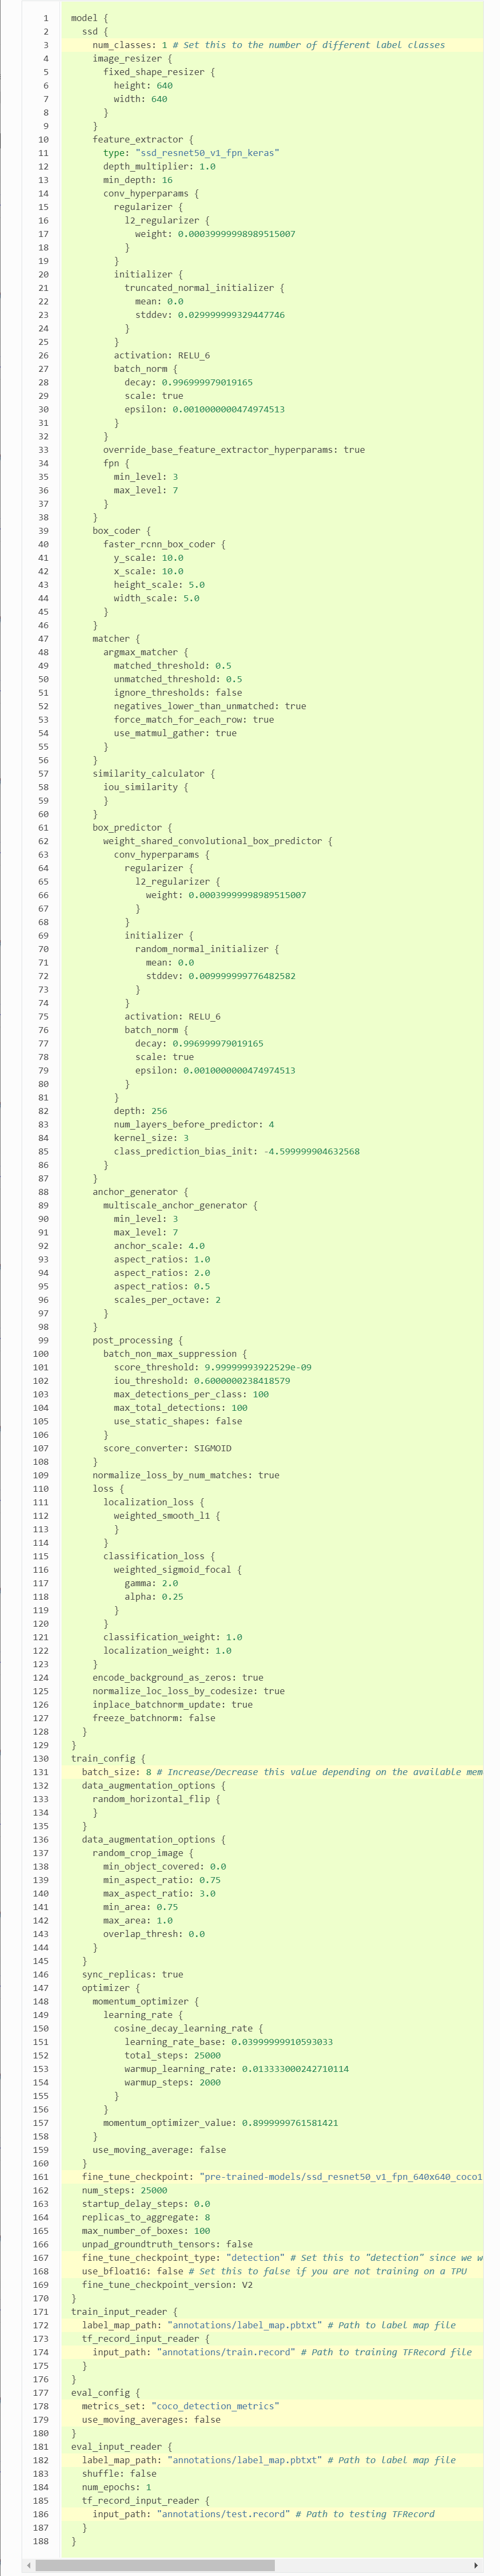



```
Line 3: num_classes: 1 # Set this to the number of different label classes

Line 131: batch_size: 8 # Increase/Decrease this value depending on the available memory (Higher values require more memory and vice-versa)

Line 161: fine_tune_checkpoint: "pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0" # Path to checkpoint of pre-trained model

Line 167: fine_tune_checkpoint_type: "detection" # Set this to "detection" since we want to be training the full detection model

Line 168:  use_bfloat16: false # Set this to false if you are not training on a TPU

Line 172: label_map_path: "annotations/label_map.pbtxt" # Path to label map file

Line 174: input_path: "annotations/train.record" # Path to training TFRecord file

Line 178: metrics_set: "coco_detection_metrics"

Line 179: use_moving_averages: false

Line 182: label_map_path: "annotations/label_map.pbtxt" # Path to label map file

Line 186:  input_path: "annotations/test.record" # Path to testing TFRecord
```



In [ ]:
#cd into training_demo
%cd /TensorFlow/workspace/training_demo
#start the Tensorboard
%load_ext tensorboard
%tensorboard --logdir=models/my_custom_model

In [ ]:
#@title # **9) RUN: Training the model**

#@markdown **This next code will train the model. You will know it is working if after a period of time you see lines like the following:**

#@markdown *INFO:tensorflow:Step 100 per-step time 1.201s loss=1.099*

#@markdown **Once this is running go forward and read the next steps instructions**
% cd /TensorFlow/workspace/training_demo/
! python model_main_tf2.py --model_dir=models/my_custom_model --pipeline_config_path=models/my_custom_model/pipeline.config --sample_1_of_n_eval_examples=1000

/TensorFlow/workspace/training_demo
2021-02-19 06:09:00.013489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-02-19 06:09:02.828254: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-19 06:09:02.829370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-19 06:09:02.861011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-19 06:09:02.861667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-02-19 06:09:02.861710: I tensorflow/stream

# **10) USER ACTION: STOP THE MODEL TRAINING**

After a period of time (normally around every 1000 steps) a couple of checkpoint files will be saved to the /TensorFlow/workspace/training_demo/models/my_custom_model. Once the loss reaches an acceptable level (less than 2 gives fair results, shoot for less than 1 but avoid overfitting by going really close to 0) then the model can be stopped by hitting the stop icon in the code cell after the checkpoint files have been saved. Once the training has been stopped the model can then be exported to be used later (done in the following RUN cell).


In [ ]:
#@title # **11) RUN: EXPORT THE CUSTOM MODEL**

#@markdown This cell will run through the results of the model training and export the appropriate files in the correct format
! cp /TensorFlow/models/research/object_detection/exporter_main_v2.py /TensorFlow/workspace/training_demo
% cd /TensorFlow/workspace/training_demo/
! python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /TensorFlow/workspace/training_demo/models/my_custom_model//pipeline.config --trained_checkpoint_dir models/my_custom_model/ --output_directory exported-models

In [ ]:
#@title # **12) RUN: DOWNLOADING THE MODEL**

#@markdown If you wish to download the completed model then run this cell to generate a zip file and start the download. This model can be used by the NGA CODTestV1 notebook for a quick evaluation and visualization of the exported model.
!zip -r /content/exported_model.zip /TensorFlow/workspace/training_demo/exported-models/

#from google.colab import files
#files.download("/content/exported_model.zip")